In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np


In [10]:
import os
os.listdir("/kaggle/input")


['toronto-ksi-collisions-dataset']

In [12]:
persons = pd.read_csv(
    "/kaggle/input/toronto-ksi-collisions-dataset/ksi_person_level_clean.csv"
)

collisions = pd.read_csv(
    "/kaggle/input/toronto-ksi-collisions-dataset/ksi_collision_level_clean.csv"
)

persons.head()


,_id,accnum,date,time,street1,street2,offset,road_class,district,accloc,...,neighbourhood_158,hood_140,neighbourhood_140,division,geometry,collision_datetime,hour,minute,latitude,longitude
0,1,893184.0,2006-01-01,00:00:00,WOODBINE AVE,O CONNOR DR,NaN,Major Arterial,Toronto and East York,Intersection Related,...,Woodbine-Lumsden,60,Woodbine-Lumsden (60),D55,"{""coordinates"": [[-79.318797000266, 43.6995950...",2006-01-01,0.0,0.0,NaN,NaN
1,2,893184.0,2006-01-01,00:00:00,WOODBINE AVE,O CONNOR DR,NaN,Major Arterial,Toronto and East York,Intersection Related,...,Woodbine-Lumsden,60,Woodbine-Lumsden (60),D55,"{""coordinates"": [[-79.318797000266, 43.6995950...",2006-01-01,0.0,0.0,NaN,NaN
2,3,893184.0,2006-01-01,00:00:00,WOODBINE AVE,O CONNOR DR,NaN,Major Arterial,Toronto and East York,Intersection Related,...,Woodbine-Lumsden,60,Woodbine-Lumsden (60),D55,"{""coordinates"": [[-79.318797000266, 43.6995950...",2006-01-01,0.0,0.0,NaN,NaN
3,4,893184.0,2006-01-01,00:00:00,WOODBINE AVE,O CONNOR DR,NaN,Major Arterial,Toronto and East York,Intersection Related,...,Woodbine-Lumsden,60,Woodbine-Lumsden (60),D55,"{""coordinates"": [[-79.318797000266, 43.6995950...",2006-01-01,0.0,0.0,NaN,NaN
4,5,893184.0,2006-01-01,00:00:00,WOODBINE AVE,O CONNOR DR,NaN,Major Arterial,Toronto and East York,Intersection Related,...,Woodbine-Lumsden,60,Woodbine-Lumsden (60),D55,"{""coordinates"": [[-79.318797000266, 43.6995950...",2006-01-01,0.0,0.0,NaN,NaN


In [13]:
persons.shape, collisions.shape


((18957, 55), (1617, 4))

In [14]:
persons.columns


Index(['_id', 'accnum', 'date', 'time', 'street1', 'street2', 'offset',
       'road_class', 'district', 'accloc', 'traffctl', 'visibility', 'light',
       'rdsfcond', 'acclass', 'impactype', 'invtype', 'invage', 'injury',
       'fatal_no', 'initdir', 'vehtype', 'manoeuver', 'drivact', 'drivcond',
       'pedtype', 'pedact', 'pedcond', 'cyclistype', 'cycact', 'cyccond',
       'pedestrian', 'cyclist', 'automobile', 'motorcycle', 'truck',
       'trsn_city_veh', 'emerg_veh', 'passenger', 'speeding', 'ag_driv',
       'redlight', 'alcohol', 'disability', 'hood_158', 'neighbourhood_158',
       'hood_140', 'neighbourhood_140', 'division', 'geometry',
       'collision_datetime', 'hour', 'minute', 'latitude', 'longitude'],
      dtype='object')

In [15]:
def extract_lat_lon(geom):
    if pd.isna(geom):
        return pd.Series([np.nan, np.nan])
    try:
        g = json.loads(geom)
        coords = g["coordinates"][0]
        return pd.Series([coords[1], coords[0]])  # latitude, longitude
    except:
        return pd.Series([np.nan, np.nan])

persons[["latitude", "longitude"]] = persons["geometry"].apply(extract_lat_lon)

persons[["latitude", "longitude"]].head()


,latitude,longitude
0,43.699595,-79.318797
1,43.699595,-79.318797
2,43.699595,-79.318797
3,43.699595,-79.318797
4,43.699595,-79.318797


In [16]:
persons_with_coords = persons.dropna(subset=["latitude", "longitude"])

hotspots = (
    persons_with_coords
    .groupby(["latitude", "longitude"])
    .size()
    .reset_index(name="ksi_count")
    .sort_values("ksi_count", ascending=False)
)

hotspots.head(10)


,latitude,longitude,ksi_count
2120,43.674445,-79.56319,25
6006,43.821345,-79.31689,25
5692,43.797945,-79.42009,25
6072,43.836545,-79.25119,24
989,43.650845,-79.38659,23
632,43.644045,-79.37579,20
1259,43.655745,-79.38379,20
5017,43.770045,-79.26129,20
2664,43.688145,-79.30179,20
478,43.639545,-79.38269,19


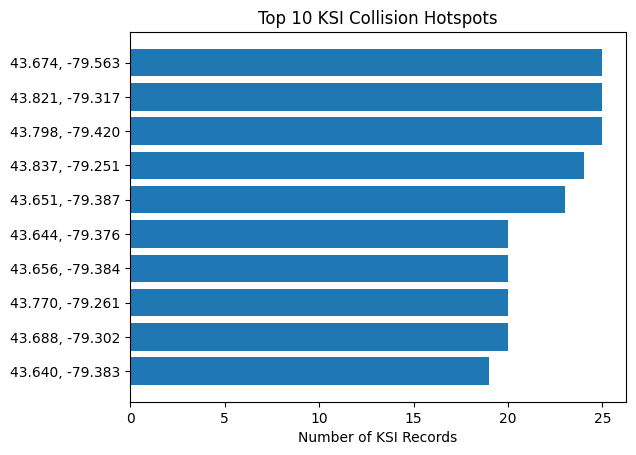

In [17]:
top10 = hotspots.head(10)

plt.figure()
plt.barh(
    range(len(top10)),
    top10["ksi_count"]
)
plt.yticks(
    range(len(top10)),
    [f"{lat:.3f}, {lon:.3f}" for lat, lon in zip(top10["latitude"], top10["longitude"])]
)
plt.xlabel("Number of KSI Records")
plt.title("Top 10 KSI Collision Hotspots")
plt.gca().invert_yaxis()
plt.show()


In [18]:
persons["year"] = pd.to_datetime(
    persons["collision_datetime"],
    errors="coerce"
).dt.year

yearly = (
    persons.dropna(subset=["year"])
    .groupby("year")
    .size()
    .reset_index(name="ksi_count")
)

yearly.head()


,year,ksi_count
0,2006.0,443
1,2007.0,468
2,2008.0,351
3,2009.0,345
4,2010.0,357


In [19]:
road_user_cols = [
    "pedestrian",
    "cyclist",
    "automobile",
    "motorcycle",
    "truck",
    "passenger",
]

road_user_counts = (
    persons[road_user_cols]
    .apply(lambda col: col.eq("Yes").sum())
    .reset_index()
)

road_user_counts.columns = ["road_user_type", "ksi_records"]
road_user_counts


,road_user_type,ksi_records
0,pedestrian,7688
1,cyclist,1986
2,automobile,17230
3,motorcycle,1684
4,truck,1169
5,passenger,7183


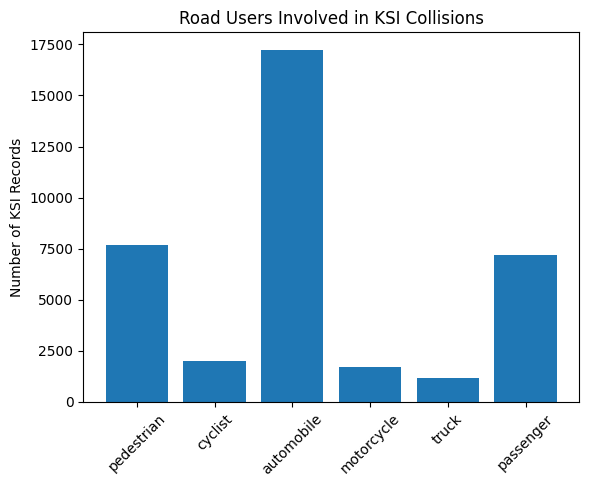

In [20]:
plt.figure()
plt.bar(
    road_user_counts["road_user_type"],
    road_user_counts["ksi_records"]
)
plt.xticks(rotation=45)
plt.ylabel("Number of KSI Records")
plt.title("Road Users Involved in KSI Collisions")
plt.show()
